<a href="https://colab.research.google.com/github/jimmy-io/Insight_project/blob/master/MODAnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My Drive/Insight/Project/MAsk-RCNN

/content/drive/My Drive/Insight/Project/MAsk-RCNN


In [0]:
!pip install keras-maskrcnn

In [0]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras
import keras_maskrcnn
import keras_retinanet 

# import keras_retinanet
from keras_maskrcnn import models
from keras_maskrcnn.utils.visualization import draw_mask
from keras_retinanet.utils.visualization import draw_box, draw_caption, draw_annotations
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import json

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# adjust this to point to your downloaded/trained model
model_path = os.path.join('/content/drive/My Drive/Insight/Project/MAsk-RCNN', 'resnet50_modanet.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {1: 'bag', 2: 'belt', 3: 'boots', 4: 'footwear', 5: 'outer', 6: 'dress', 7: 'sunglasses', 8: 'pants', 9: 'top', 10: 'shorts', 11: 'skirt', 12: 'headwear', 13: 'scarf/tie'}

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:335: UserWarning: Output "filtered_detections" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "filtered_detections" during training.
  sample_weight_mode=sample_weight_mode)
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:335: UserWarning: Output "mask_submodel" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "mask_submodel" during training.
  sample_weight_mode=sample_weight_mode)
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWar

processing time:  11.335052251815796


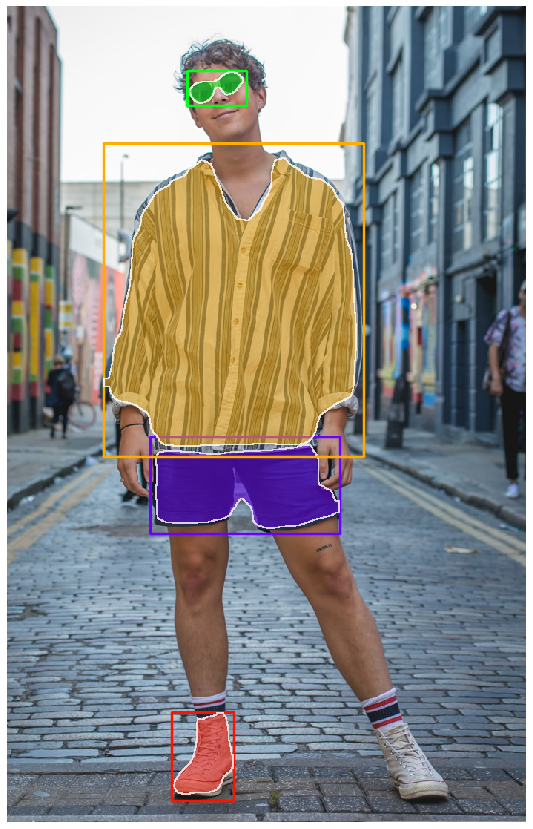

In [23]:
# load image
image = read_image_bgr('hannah2019july5.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
outputs = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

boxes  = outputs[-4][0]
scores = outputs[-3][0]
labels = outputs[-2][0]
masks  = outputs[-1][0]

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label, mask in zip(boxes, scores, labels, masks):
    if score < 0.5:
        break

    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    mask = mask[:, :, label]
    draw_mask(draw, b, mask, color=label_color(label))
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    #draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [30]:
labels

array([ 6,  9,  8,  3,  2,  2,  3,  4,  9,  6, 10,  3,  2,  3,  8,  3,  2,
        3,  3,  5,  7,  0,  2,  2,  2,  1,  9,  2,  8,  8,  3,  8,  2,  3,
        2, 10,  2,  8,  9,  3,  3,  8,  3,  8,  3, 12,  8,  3,  7,  3,  2,
        3,  4,  9,  7,  3,  2,  3,  2,  3,  3,  3,  2,  8,  2,  3,  3,  2,
        2,  2, 11,  2,  3,  5,  2,  2,  3,  3,  8, 12,  0,  2,  3,  0,  7,
        3,  2,  3,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      dtype=int32)